## Experiment 10: Feature extraction and reverse image search
Adapted from https://nextjournal.com/ml4a/image-search

Import modules

In [1]:
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt

import os
import keras
from keras.preprocessing import image
from keras.applications.imagenet_utils import decode_predictions, preprocess_input
from keras.models import Model

Using TensorFlow backend.


Load and cleanup the data file

In [2]:
# Load the csv file containing the posts
# Use only "URL" and "Total Interactions" columns
ingr_posts_df = pd.read_csv("Datasets/ingr/ingr.csv",
                            usecols=["URL", "Total Interactions"])[
    ["URL", "Total Interactions"]]
ingr_posts_df["image_dir"] = "Datasets/ingr/images/"  # Path to where your images are

tovima_posts_df = pd.read_csv("Datasets/tovima/tovima.csv",
                              usecols=["URL", "Total Interactions"]).head(522)[
    ["URL", "Total Interactions"]]
tovima_posts_df["image_dir"] = "Datasets/tovima/images/"  # Path to where your images are

# Combine the two dataframes into a single one
posts_df = pd.concat([ingr_posts_df, tovima_posts_df], ignore_index=True)

# Create a column storing the image path of each post
posts_df['image_path'] = posts_df.apply(
    lambda x: x["image_dir"] + x["URL"].split("/")[-1].strip() + ".jpg", axis=1)

# Drop rows with missing values values
posts_df = posts_df.dropna().reset_index(drop=True)

# Filter out rows with "Total Interactions" values below 0.05 quantile and above 0.95 quantile
posts_df = posts_df.loc[(posts_df["Total Interactions"] >= posts_df[
    "Total Interactions"].quantile(.05)) & (posts_df["Total Interactions"] <= posts_df[
    "Total Interactions"].quantile(.95))].reset_index(drop=True)
posts_df

,URL,Total Interactions,image_dir,image_path
0,https://www.facebook.com/293834325961/posts/10...,2,Datasets/ingr/images/,Datasets/ingr/images/10159636104980962.jpg
1,https://www.facebook.com/293834325961/posts/10...,2,Datasets/ingr/images/,Datasets/ingr/images/10159636289825962.jpg
2,https://www.facebook.com/293834325961/posts/10...,28,Datasets/ingr/images/,Datasets/ingr/images/10159635983895962.jpg
3,https://www.facebook.com/293834325961/posts/10...,10,Datasets/ingr/images/,Datasets/ingr/images/10159635136250962.jpg
4,https://www.facebook.com/293834325961/posts/10...,7,Datasets/ingr/images/,Datasets/ingr/images/10159635038980962.jpg
...,...,...,...,...
1026,https://www.facebook.com/184884834877395/posts...,0,Datasets/tovima/images/,Datasets/tovima/images/4394677827231387.jpg
1027,https://www.facebook.com/184884834877395/posts...,7,Datasets/tovima/images/,Datasets/tovima/images/4393836503982186.jpg
1028,https://www.facebook.com/184884834877395/posts...,1,Datasets/tovima/images/,Datasets/tovima/images/4394137847285385.jpg
1029,https://www.facebook.com/184884834877395/posts...,1,Datasets/tovima/images/,Datasets/tovima/images/4392883707410799.jpg


Load a pretrained model

In [ ]:
model = keras.applications.VGG16(weights='imagenet', include_top=True)
model.summary()

Function to load and preprocess images

shape of x:  (1, 224, 224, 3)
data type:  float32


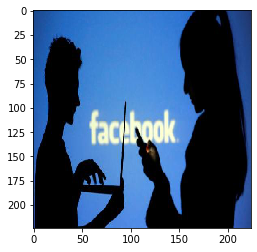

In [4]:
def load_image(path):
    img = image.load_img(path, target_size=model.input_shape[1:3])
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    return img, x

img_path = posts_df["image_path"][0]
img, x = load_image(img_path)

print("shape of x: ", x.shape)
print("data type: ", x.dtype)
plt.imshow(img)

In [ ]:
# forward the image through the network
predictions = model.predict(x)

# print out the 
for _, pred, prob in decode_predictions(predictions)[0]:
    print("predicted %s with probability %0.3f" % (pred, prob))

In [6]:
feat_extractor = Model(inputs=model.input, outputs=model.get_layer("fc2").output)
feat_extractor.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0   

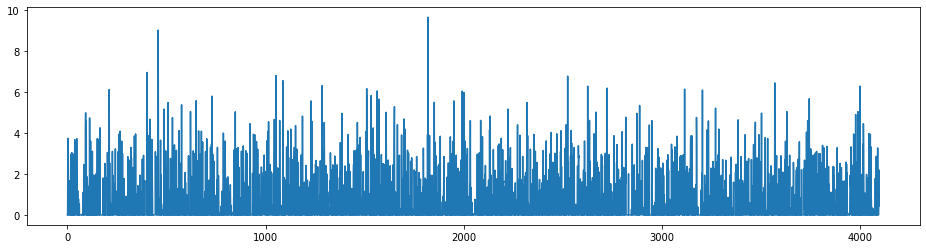

In [7]:
img, x = load_image(posts_df["image_path"][0])
feat = feat_extractor.predict(x)

plt.figure(figsize=(16,4))
plt.plot(feat[0])

In [8]:
import time
tic = time.clock()


features = []
for i, image_path in enumerate(posts_df["image_path"]):
    if i % 100 == 0:
        toc = time.clock()
        elap = toc-tic;
        print("analyzing image %d / %d. Time: %4.4f seconds." % (i, len(posts_df["image_path"]),elap))
        tic = time.clock()
    img, x = load_image(image_path);
    feat = feat_extractor.predict(x)[0]
    features.append(feat)

print('finished extracting features for %d images' % len(posts_df["image_path"]))

analyzing image 0 / 1031. Time: 0.0001 seconds.
analyzing image 100 / 1031. Time: 54.4672 seconds.
analyzing image 200 / 1031. Time: 54.4068 seconds.
analyzing image 300 / 1031. Time: 54.3725 seconds.
analyzing image 400 / 1031. Time: 54.2952 seconds.
analyzing image 500 / 1031. Time: 54.3782 seconds.
analyzing image 600 / 1031. Time: 54.3856 seconds.
analyzing image 700 / 1031. Time: 54.3736 seconds.
analyzing image 800 / 1031. Time: 54.3532 seconds.
analyzing image 900 / 1031. Time: 54.3861 seconds.
analyzing image 1000 / 1031. Time: 54.3857 seconds.
finished extracting features for 1031 images


In [9]:
from sklearn.decomposition import PCA

features = np.array(features)
pca = PCA(n_components=300)
pca.fit(features)

PCA(copy=True, iterated_power='auto', n_components=300, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

In [10]:
pca_features = pca.transform(features)

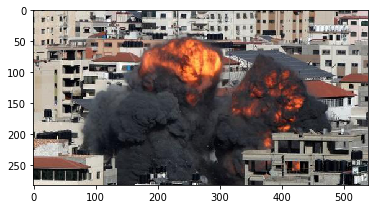

In [33]:
import random

# grab a random query image
query_image_idx = int(len(posts_df["image_path"]) * random.random())

# let's display the image
img = image.load_img(posts_df["image_path"][query_image_idx])
plt.imshow(img)

In [34]:
from scipy.spatial import distance

similar_idx = [ distance.cosine(pca_features[query_image_idx], feat) for feat in pca_features ]

In [35]:
idx_closest = sorted(range(len(similar_idx)), key=lambda k: similar_idx[k])[1:6]

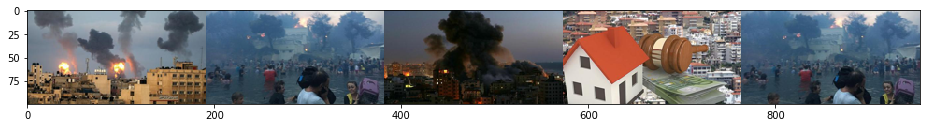

In [36]:
# load all the similarity results as thumbnails of height 100
thumbs = []
for idx in idx_closest:
    img = image.load_img(posts_df["image_path"][idx])
    img = img.resize((int(img.width * 100 / img.height), 100))
    thumbs.append(img)

# concatenate the images into a single image
concat_image = np.concatenate([np.asarray(t) for t in thumbs], axis=1)

# show the image
plt.figure(figsize = (16,12))
plt.imshow(concat_image)

In [37]:
def get_closest_images(query_image_idx, num_results=5):
    distances = [ distance.cosine(pca_features[query_image_idx], feat) for feat in pca_features ]
    idx_closest = sorted(range(len(distances)), key=lambda k: distances[k])[1:num_results+1]
    return idx_closest

def get_concatenated_images(indexes, thumb_height):
    thumbs = []
    for idx in indexes:
        img = image.load_img(posts_df["image_path"][idx])
        img = img.resize((int(img.width * thumb_height / img.height), thumb_height))
        thumbs.append(img)
    concat_image = np.concatenate([np.asarray(t) for t in thumbs], axis=1)
    return concat_image

Text(0.5, 1.0, 'query image (771)')

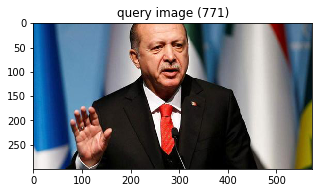

In [52]:
# do a query on a random image
query_image_idx = int(len(posts_df["image_path"]) * random.random())
idx_closest = get_closest_images(query_image_idx)
query_image = get_concatenated_images([query_image_idx], 300)
results_image = get_concatenated_images(idx_closest, 200)

# display the query image
plt.figure(figsize = (5,5))
plt.imshow(query_image)
plt.title("query image (%d)" % query_image_idx)

Text(0.5, 1.0, 'result images')

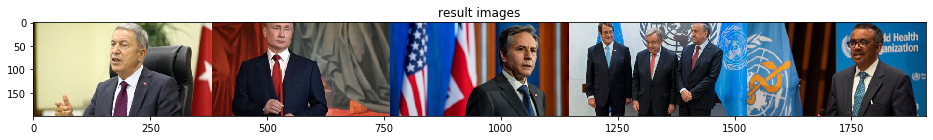

In [53]:
# display the resulting images
plt.figure(figsize = (16,12))
plt.imshow(results_image)
plt.title("result images")

In [20]:
import pickle

pickle.dump([posts_df["image_path"], pca_features, pca], open('features_posts.p', 'wb'))